LSTM model to predict filtered shear stress using on Amplitude features

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from keras.utils import plot_model
import time
import tensorflow as tf
import h5py

In [ ]:
# Function to create data with timesteps

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  #last column is assumed to be the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)



In [ ]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'V_filt':data['V_filt'].ravel(), 'Vel_pc':data['Vel_pc'].ravel()})  
df1 = a_t.merge(m_t, on='Time')

data2 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_run1_pp_wAmp.mat')
df2 = pd.DataFrame({'freqQAmpI_filt':data2['freqQAmpI_filt'][3786:136185].ravel(), 'freqQAmpI_filt_pc':data2['freqQAmpI_filt_pc'].ravel()})

df = pd.concat([df1, df2], axis=1)

df = df[['freqQAmpI_filt', 'freqQAmpI_filt_pc', 'SS']]
print("Input data:\n", df)


Input data:
         freqQAmpI_filt  freqQAmpI_filt_pc        SS
0         31453.223522                0.0  5.656166
1         31438.277060                0.0  5.657157
2         31421.341616                0.0  5.658317
3         31409.798761                0.0  5.659499
4         31398.815589                0.0  5.660404
...                ...                ...       ...
132394    31055.686766                0.0  5.471059
132395    31041.955345                0.0  5.474545
132396    31035.059531                0.0  5.478286
132397    31020.001291                0.0  5.481751
132398    31012.016780                0.0  5.484813

[132399 rows x 3 columns]


In [ ]:
# Preprocessing

arr = df.to_numpy()
n_steps = 300
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))


Features shape, X =  (132099, 300, 2)
Target shape, Y =  (132099,)


In [ ]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

# Normalize the features
scaler = MinMaxScaler()
num_instances, num_time_steps, num_features = X_train.shape
X_train = scaler.fit_transform(np.reshape(X_train, (-1, num_features)))
X_train = np.reshape(X_train, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = X_val.shape
X_val = scaler.transform(np.reshape(X_val, (-1, num_features)))
X_val = np.reshape(X_val, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = x_test.shape
x_test = scaler.transform(np.reshape(x_test, (-1, num_features)))
x_test = np.reshape(x_test, (num_instances, num_time_steps, num_features))

print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))


Training: (95111, 300, 2)
Validation: (10568, 300, 2)
Testing: (26420, 300, 2)


Epoch 1/10
2973/2973 [==============================] - 71s 24ms/step - loss: 0.9080 - val_loss: 0.0233
Epoch 2/10
2973/2973 [==============================] - 70s 24ms/step - loss: 0.0166 - val_loss: 0.0232
Epoch 3/10
2973/2973 [==============================] - 67s 23ms/step - loss: 0.0166 - val_loss: 0.0242
Epoch 4/10
2973/2973 [==============================] - 68s 23ms/step - loss: 0.0124 - val_loss: 0.0032
Epoch 5/10
2973/2973 [==============================] - 69s 23ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 6/10
2973/2973 [==============================] - 69s 23ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 7/10
2973/2973 [==============================] - 70s 24ms/step - loss: 8.7504e-04 - val_loss: 0.0020
Epoch 8/10
2973/2973 [==============================] - 70s 24ms/step - loss: 7.3486e-04 - val_loss: 9.8339e-04
Epoch 9/10
2973/2973 [==============================] - 70s 24ms/step - loss: 6.0207e-04 - val_loss: 0.0013
Epoch 10/10
2973/2973 [=========================

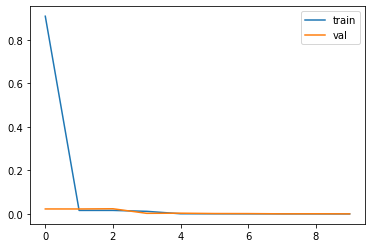

---Training time: 700.37403488 seconds ---


In [ ]:
# Build the model

np.random.seed(0)   # To get reproducible results
#tf.random.set_seed(1)

model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(16))
#model.add(Flatten())
model.add(Dense(1, kernel_initializer='normal', activation='linear'))
model.compile(loss='mse', optimizer='adam')

start_time = time.time()
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300, 32)           4480      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 7,633
Trainable params: 7,633
Non-trainable params: 0
_________________________________________________________________
None


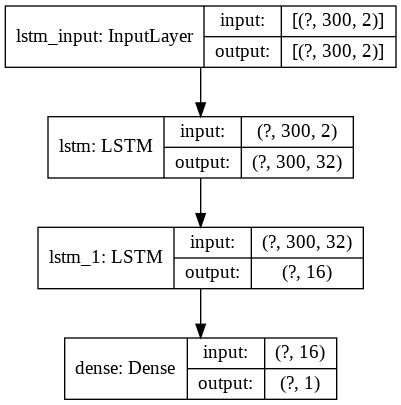

In [ ]:
print(model.summary())
plot_model(model, show_shapes=True)
#model.save('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/models/LSTM_ss.h5')

In [ ]:
# Evaluate the model

y_predTrain = model.predict(X_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  

start_time = time.time()
y_predTest = model.predict(x_test)
end_time = time.time()

test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("R2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_r2, val_r2, test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_rmse, val_rmse, test_rmse))

print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))

R2 scores: Train - 0.97123, Validation - 0.96213, Test - 0.92491
RMSE scores: Train - 0.02180, Validation - 0.02871, Test - 0.03960

---Time for Test data prediction: 8.21829867 seconds ---


Text(0.5, 1.0, 'Shear Stress prediction using LSTM model')

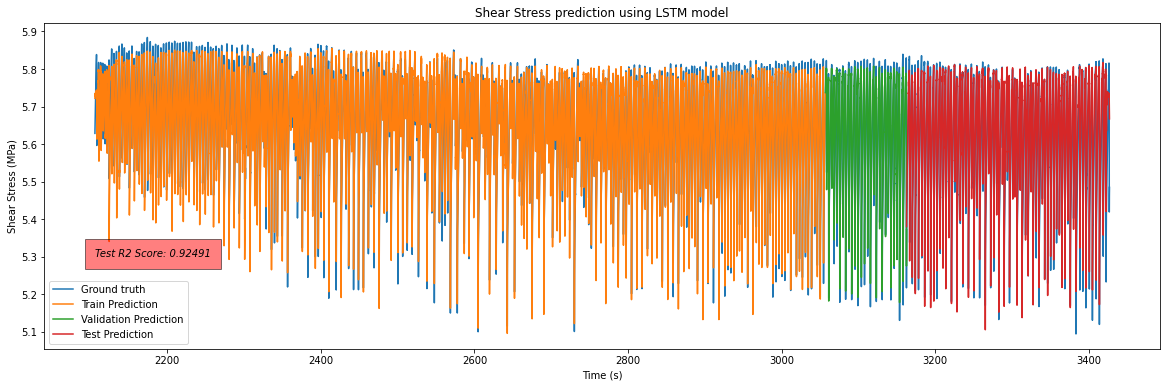

In [ ]:
# Overall plot

ttime = df1['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.1, shuffle=False)

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf)
plt.plot(traintime, y_predTrain)
plt.plot(valtime, y_predVal)
plt.plot(testtime, y_predTest)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.text(ttime.iloc[0], 5.3, 'Test R2 Score: %0.5f' %(test_r2), style='italic', bbox=dict(facecolor='red', alpha=0.5, pad=10))
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('Shear Stress prediction using LSTM model')


In [ ]:
# Save

hf = h5py.File('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/predictions/lstm_amp_ss2.h5', 'w')
hf.create_dataset('y_predTrain', data=y_predTrain)
hf.create_dataset('y_predVal', data=y_predVal)
hf.create_dataset('y_predTest', data=y_predTest)
hf.close()



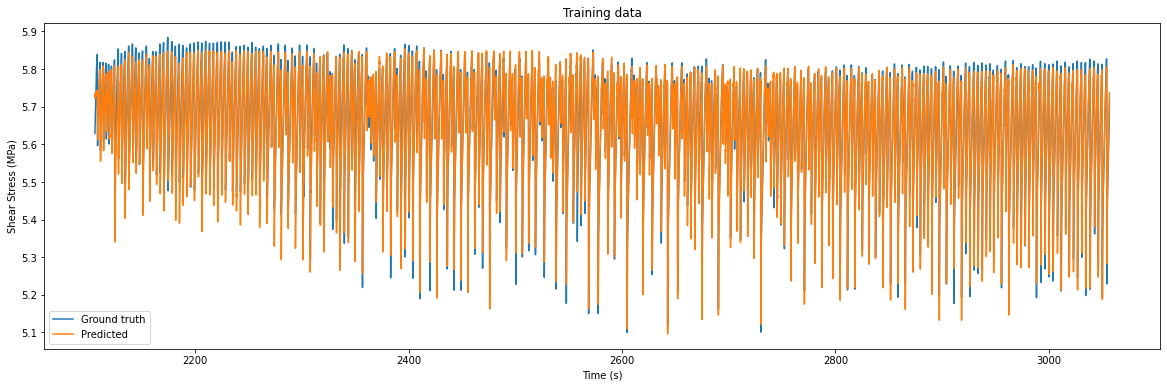

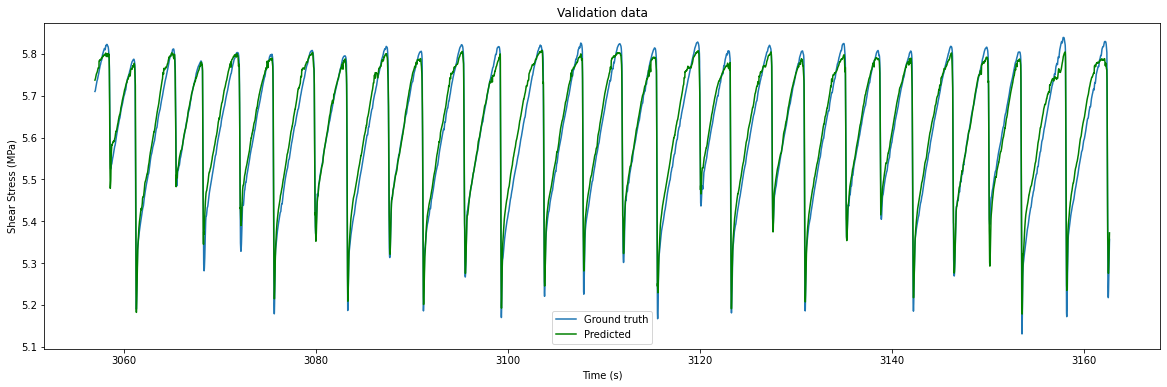

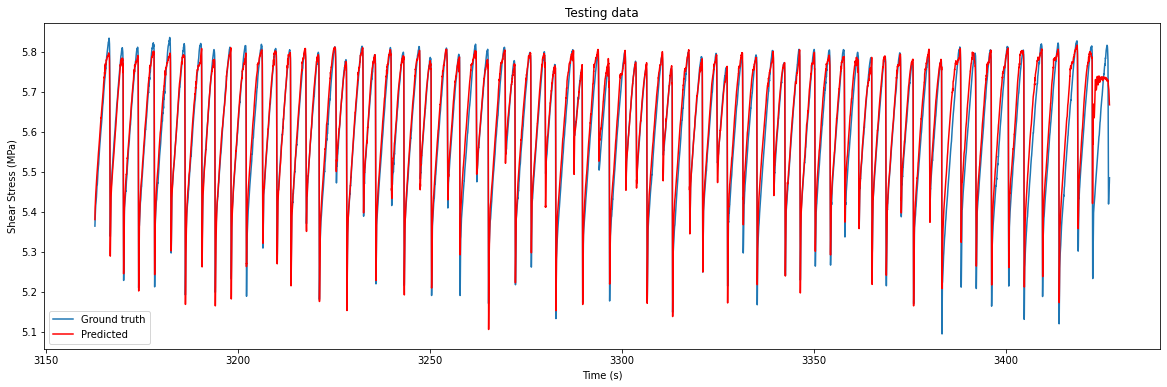

In [ ]:
# Individual plots

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train, y_predTrain, 'Training data', '')
results_plot(2, valtime, Y_val, y_predVal, 'Validation data', 'g')
results_plot(3, testtime, y_test, y_predTest, 'Testing data', 'r')


Text(0.5, 1.0, 'Detailed View, Testing Data')

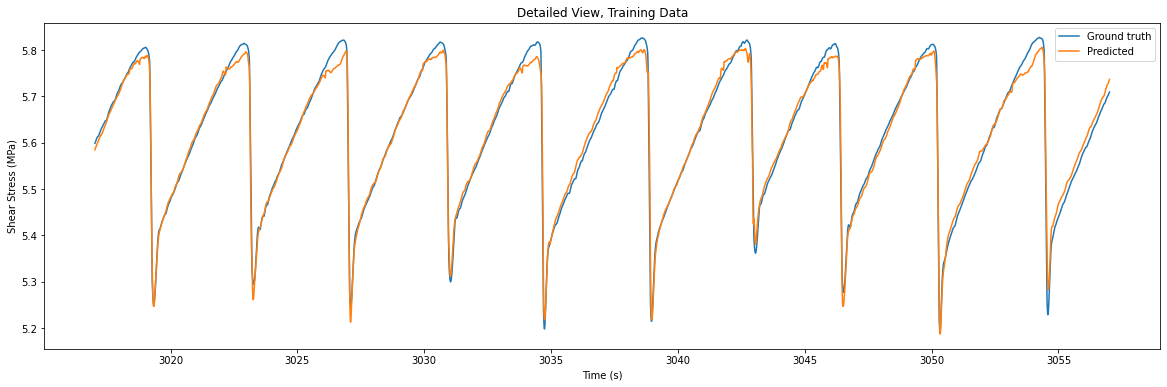

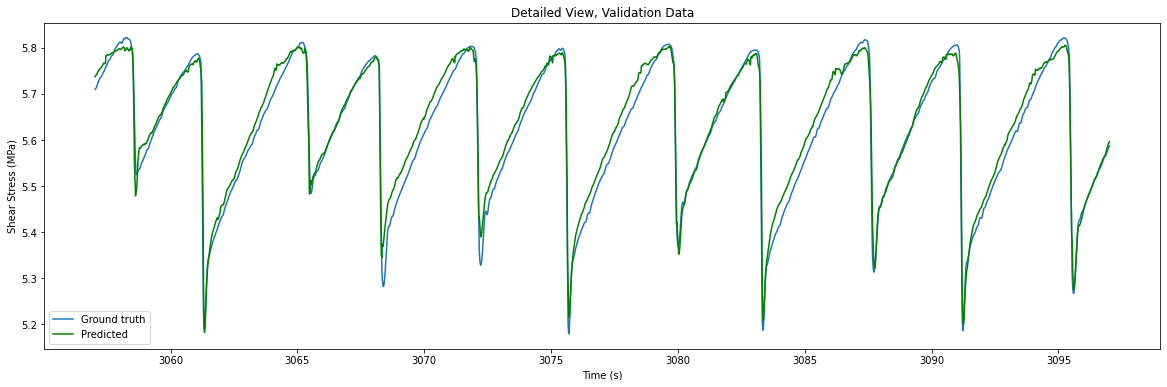

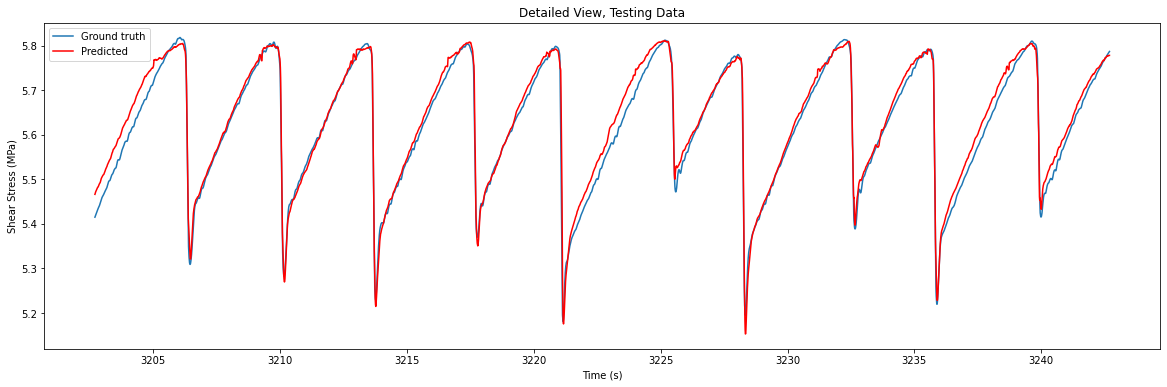

In [ ]:
# Detailed view of the plots

n=4000

fig = plt.figure(4, figsize=(20,6))
plt.plot(traintime[-n:], Y_train[-n:])
plt.plot(traintime[-n:], y_predTrain[-n:])
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(valtime[:n], Y_val[:n])
plt.plot(valtime[:n], y_predVal[:n], 'g')
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Validation Data')

st_i = 4000
fig = plt.figure(6, figsize=(20,6))
plt.plot(testtime[st_i:st_i+n], y_test[st_i:st_i+n])
plt.plot(testtime[st_i:st_i+n], y_predTest[st_i:st_i+n], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')
